<a href="https://colab.research.google.com/github/bflaggs/DSPS_BFlaggs/blob/main/lab/Fit_Models_to_Microlensing_lightcurves.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fitting two models to Microlensing photometry

In this exercise, we will fit a Gaussian distribution and a Cauchy distribution to a light curve of a single-lens microlensing event. 

    

# initial imports

In [2]:
!pip install emcee
!pip install corner

     |████████████████████████████████| 45 kB 3.8 MB/s 


We will also need these packags: pandas, matplotlib, numpy, emcee, corner

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import emcee
import corner
from scipy.optimize import minimize
%matplotlib inline

# Read in the input dataset

In [4]:
# Path to OGLE data: https://raw.githubusercontent.com/Somayeh91/Data_Science_class_UD_fall_2021/main/data/OGLE_2012_BLG_1323.csv
# Path to Roman data: https://raw.githubusercontent.com/Somayeh91/Data_Science_class_UD_fall_2021/main/data/mag.dcnormffp_0_82_1902.det.lc.W149.csv 
ogle_data = pd.read_csv("https://raw.githubusercontent.com/Somayeh91/Data_Science_class_UD_fall_2021/main/data/OGLE_2012_BLG_1323.csv")
roman_data = pd.read_csv("https://raw.githubusercontent.com/Somayeh91/Data_Science_class_UD_fall_2021/main/data/mag.dcnormffp_0_82_1902.det.lc.W149.csv")

In [6]:
print(ogle_data)
print(roman_data)

      Unnamed: 0             t         A     A_err
0              0  2.455261e+06  1.007395  0.003711
1              1  2.455262e+06  1.001844  0.003691
2              2  2.455263e+06  0.993574  0.005491
3              3  2.455266e+06  1.010183  0.003722
4              4  2.455267e+06  1.000000  0.003684
...          ...           ...       ...       ...
3784        3784  2.456234e+06  1.012045  0.003729
3785        3785  2.456235e+06  1.013911  0.003735
3786        3786  2.456239e+06  1.010183  0.003722
3787        3787  2.456240e+06  1.017654  0.003749
3788        3788  2.456243e+06  1.016717  0.004682

[3789 rows x 4 columns]
       Unnamed: 0            t         A     A_err
0               0   112.505461  1.003115  0.003991
1               1   112.515987  1.002986  0.003992
2               2   112.526513  0.998191  0.003992
3               3   112.537040  0.998995  0.003991
4               4   112.547566  0.997990  0.003991
...           ...          ...       ...       ...
38563 

#Visualize the data

Text(0, 0.5, 'Magnification')

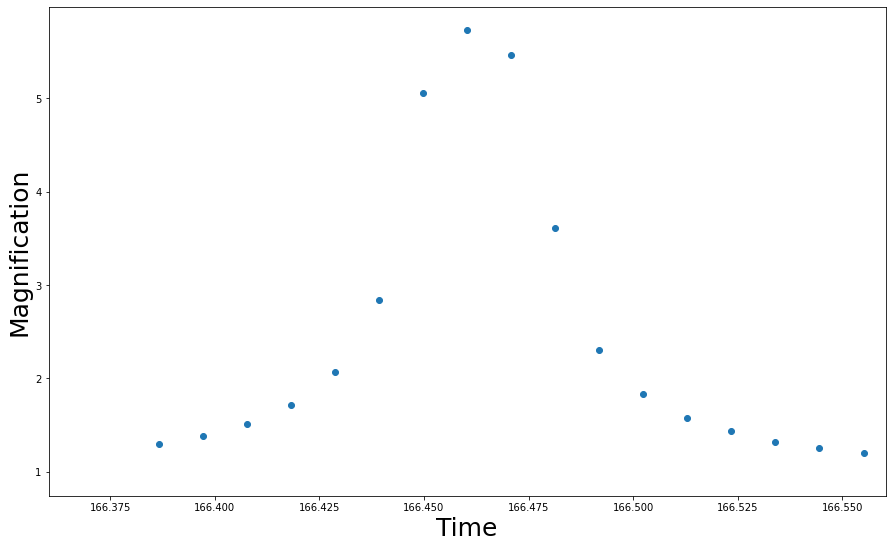

In [12]:
plt.figure(figsize=(15,9))
plt.errorbar(roman_data.t, roman_data.A, yerr=roman_data.A_err, fmt='o')

dt = 0.1
peak = roman_data.t[np.argmax(roman_data.A)]
plt.xlim(peak-dt, peak+dt)

plt.xlabel("Time", size=25)
plt.ylabel("Magnification", size=25)

# Define the PSPL model and the Cauchy distributions


PSPL model:

$F(t) = f_s \times A(t) + (1-f_s)$

$A(t) = \frac{u(t)^2 +2}{u(t)\times \sqrt{u(t)^2 + 4}}$

$u(t) = \sqrt {{u_0}^2+ ({\frac {t-t_0}{t_E}})^2}$

Cauchy model:

$C(t) = 1+ \frac {amp}{{1+|\frac{t-t_0}{\sigma}|}^{2b}}$


In [14]:
def PSPL(x, x0, tE, u0, fs):
  u = np.sqrt((u0**2) + ((x - x0) / tE)**2)
  A = (u**2 + 2) / (u * np.sqrt(u**2 + 4))
  F = fs * A + (1-fs)
  return F


def cauchy(x, amp, x0, sigma, b):
  denom = 1 + (np.abs((x - x0) / sigma))**(2*b)
  return 1 + (amp / denom)


def L1(arg, x, y, func=PSPL):
  return np.sum(abs(y - func(x, *arg)))


def L2(arg, x, y, func=PSPL):
  return np.sum((y - func(x, *arg))**2)


def chi2(arg, x, y, s, func=PSPL):
  return np.sum(((y - func(x, *arg)) / s)**2)


L2 unit test: result should be 111.93751462 -8.33237568: [111.93751456  -8.33237566]
chi2 unit test: result should be 104.93611121 -7.21374685: [104.93609323  -7.21374439]


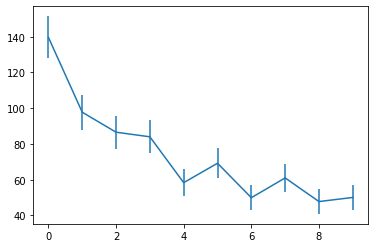

In [16]:
#Unit test

def line(a, b, x):
  return a*x + b
np.random.seed(222)
y = np.array([120, 95, 82, 74, 66, 62, 59, 51, 53, 47])
y = y + np.random.randn(len(y)) * 10
yerr = np.sqrt(y)
x = np.arange(len(y))
plt.errorbar(x, y, yerr=yerr);
print("L2 unit test: result should be 111.93751462 -8.33237568:", minimize(L2, (10,40), args=(x, y, line)).x)
print("chi2 unit test: result should be 104.93611121 -7.21374685:", minimize(chi2, (10,40), args=(x, y, yerr, line)).x)


# Fit the two functions to the data by minimizing an objective function 


Use the l1 function as your objective function.

In [18]:
# Fitting the PSPL function to data by minimizing L1

x = roman_data.t.values
y = roman_data.A.values

# Initial guesses for PSPL function
initialGuess = [peak, 0.1, 0.02, 0.46]

minimize(L1, initialGuess, args=(x, y, PSPL))



      fun: 125.37309014239274
 hess_inv: array([[ 3.59603349e-07, -1.13375679e-07,  2.58950589e-06,
         2.46579748e-05],
       [-1.13375679e-07,  5.52571104e-06, -3.89201142e-05,
        -3.33451986e-04],
       [ 2.58950589e-06, -3.89201142e-05,  3.07195403e-04,
         2.59401970e-03],
       [ 2.46579748e-05, -3.33451986e-04,  2.59401970e-03,
         2.21530433e-02]])
      jac: array([-1.83201981, 41.15000057,  2.69372749,  0.65974045])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 810
      nit: 23
     njev: 133
   status: 2
  success: False
        x: array([1.66463763e+02, 4.94063712e-02, 2.92359193e-01, 1.94455870e+00])

In [ ]:
# Fitting the Cauchy function to data by minimizing L1

.
.
.
.

In [ ]:
# Visualizing the results

plt.figure(figsize=(15,9))

.
.
.
.

# Fit the two functions to the data by minimizing an objective function 


Use the l2 function as your objective function.

In [ ]:
# Fitting the PSPL function to data by minimizing L2

.
.
.
.

In [ ]:
# Fitting the Cauchy function to data by minimizing L2

.
.
.
.

In [ ]:
# Visualizing the results

plt.figure(figsize=(15,9))

.
.
.
.


# Fit the two functions to the data by minimizing an objective function 


Use the ${\chi}^2$ function as your objective function.

In [ ]:
# Fitting the PSPL function to data by minimizing the chi-squared function


.
.
.
.

In [ ]:
# Fitting the Cauchy function to data by minimizing the chi-squared function


.
.
.
.

In [ ]:
# Visualizing the results

plt.figure(figsize=(15,9))

.
.
.
.


# Now let's fit a PSPL and a Cauchy with MCMC!



For fitting a PSPL model:

In [ ]:
# define log likelihood function
def log_likelihood....

.
.
.
.


In [ ]:
# define log prior function

def log_prior...


.
.
.
.


In [ ]:
# define log probability function

def log_probability...

.
.
.
.


In [ ]:
#initial guess
ig = [peak, .1, 0.02, 0.464796]

In [ ]:
#initialize walkers
nwalkers = 32
ndim = len(ig)

In [ ]:
pos = np.array(ig) + 1e-4 * np.random.randn(nwalkers, ndim)

In [ ]:
pos.shape

In [ ]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(x, y, s))

In [ ]:
sampler.run_mcmc(pos, 5000, progress=True);

In [ ]:
samples = sampler.get_chain()

In [ ]:
samples.shape

In [ ]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)

In [ ]:
mcmc = np.zeros((ndim, 3))
for i in range(ndim):
  mcmc[i] = np.percentile( flat_samples[:,i], [16, 50, 84])
params_PSPL = mcmc[:,1]

In [ ]:
plt.rcParams["font.size"]= 13
fig = corner.corner(
    flat_samples, labels=["t0", "tE", "u0", "fs"], truths=mcmc[:,1]);


In [ ]:
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()

for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [ ]:
# zoom in: the beginning of the chain should be cut
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()

for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, 100)#len(samples))
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

For fitting a Cauchy distribution:

In [ ]:
def log_prior....


In [ ]:
def log_likelihood....

In [ ]:
def log_probability....

In [ ]:
#initial guess
ig = [max(y), peak, 1, .1]

In [ ]:
#initialize walkers
nwalkers = 32
ndim = len(ig)

In [ ]:
pos = np.array(ig) + 1e-4 * np.random.randn(nwalkers, ndim)

In [ ]:
pos.shape

In [ ]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(x, y, s))

In [ ]:
sampler.run_mcmc(pos, 5000, progress=True);

In [ ]:
samples = sampler.get_chain()

In [ ]:
samples.shape

In [ ]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)

In [ ]:
mcmc = np.zeros((ndim, 3))
for i in range(ndim):
  mcmc[i] = np.percentile( flat_samples[:,i], [16, 50, 84])
params_cauchy = mcmc[:,1]

In [ ]:

plt.rcParams["font.size"]= 13
fig = corner.corner(
    flat_samples, labels=["Amplitude","x0","flattness","sigma"], truths=mcmc[:,1]);


In [ ]:
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()

for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [ ]:
# zoom in: the beginning of the chain should be cut
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()

for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, 100)#len(samples))
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [ ]:
plt.figure(figsize=(15,9))
dt = .1
x_new = np.linspace(min(x), max(x), len(x)*100)
plt.errorbar(df.t,df.A, yerr=df.A_err, fmt = '-o', ms=16,color='grey', zorder = -10, label = 'data')
plt.plot(x_new, PSPL(x_new, *params_PSPL),linewidth=3,color='red', label = 'PSPL fit')
plt.plot(x_new, cauchy(x_new, *params_cauchy),linewidth=3,color = 'orange', label = 'Cauchy fit')
peak = df.t[np.argmax(df.A)]
plt.xlim(peak-dt,peak+dt)
plt.xlabel('Time-peak (days)')
plt.ylabel('Magnification')
plt.legend()